In [150]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.
import netwulf as nw


## Importando dados do CDA Cotas de Fundos

In [151]:
df = pd.read_csv("funds.csv", sep = ";", decimal=",", encoding="latin1")

## Selecionando apenas as colunas necessárias

In [206]:
funds = df[["CNPJ_FUNDO", "DENOM_SOCIAL", "VL_MERC_POS_FINAL", "CNPJ_FUNDO_COTA", "NM_FUNDO_COTA"]]

## Normalizando os dados que serão utilizados nas Edges

In [207]:
min_max_scaler = MinMaxScaler()
normalized = min_max_scaler.fit_transform(funds[["VL_MERC_POS_FINAL"]])
funds["WEIGHT"] = normalized
funds["WEIGHT"] = funds["WEIGHT"] * 10000

<ipython-input-207-a60cf6bf102d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["WEIGHT"] = normalized
<ipython-input-207-a60cf6bf102d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["WEIGHT"] = funds["WEIGHT"] * 10000


## Criando Graph com todos os dados para gerar as Communities

In [208]:
G = nx.from_pandas_edgelist(df = funds, source = "CNPJ_FUNDO", target = "CNPJ_FUNDO_COTA", create_using=nx.Graph())
#G2.add_nodes_from(nodes_for_adding=funds["CNPJ_FUNDO"].to_list())


## Algoritmo de [Clauset-Newman-Moore](http://ece-research.unm.edu/ifis/papers/community-moore.pdf)

In [209]:
communities = community.greedy_modularity_communities(G)

## Selecionando Communities para plotagem

In [210]:
comm_sample = [comm for comm in communities if len(comm) > 10 and len(comm) < 20]

In [211]:
funds_comm = funds[funds["CNPJ_FUNDO"].isin(comm_sample[0])]

## Criando um Graph Direcionado com a Community selecionada

In [212]:
G_comm = nx.from_pandas_edgelist(df = funds_comm, source = "CNPJ_FUNDO", target = "CNPJ_FUNDO_COTA", edge_attr= "WEIGHT",create_using=nx.DiGraph())

## Criando dataset com PL dos fundos

In [213]:
funds_group = funds_comm.groupby(["CNPJ_FUNDO"]).sum().drop(columns = ["CNPJ_FUNDO_COTA", "WEIGHT"]).reset_index(level = 0)
funds_group_missing = funds_comm[~funds_comm["CNPJ_FUNDO_COTA"].isin(funds_group["CNPJ_FUNDO"].to_list())].groupby(["CNPJ_FUNDO_COTA"]).sum().drop(columns = ["CNPJ_FUNDO", "WEIGHT"]).reset_index(level = 0).rename(columns = {"CNPJ_FUNDO_COTA" : "CNPJ_FUNDO"})
funds_values = pd.concat([funds_group, funds_group_missing])
funds_values = funds_values.set_index("CNPJ_FUNDO")

In [214]:
min_max_scaler = MinMaxScaler()
normalized = min_max_scaler.fit_transform(funds_values[["VL_MERC_POS_FINAL"]])
funds_values["WEIGHT"] = normalized
funds_values["WEIGHT"] = funds_values["WEIGHT"] * 1000

## Criando Lista com tamanhos dos Nodes

In [215]:
nodes_size = [funds_values.loc[node][1] for node in G_comm.nodes()]

## Criando Lista com tamanho das Edges

In [216]:
edges_width = [d["WEIGHT"] for s, t, d in G_comm.edges(data = True)]

## Plotagem do Graph

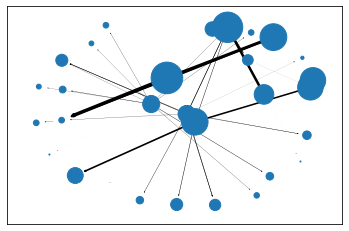

In [217]:

pos = nx.spring_layout(G_comm) 

nx.draw_networkx_nodes(G_comm, pos, node_size=nodes_size)

nx.draw_networkx_edges(G_comm, pos, width=edges_width, arrowsize=2)

plt.axis("off")
plt.show()





## [Pyvis](https://pyvis.readthedocs.io/en/latest/)

## [Netwulf](https://netwulf.readthedocs.io/en/latest/)